# Chronological Drift in the Ember Dataset

This example demonstrates the drift tracking features of Goko. 

We start by importing the correct things, and sorting the ember dataset (training + test) by appearence date. We build the covertree on everything before July 2018, and then feed the data in chrological order to the covertree and track the KL divergence.

The major flaw with this experiment is the lack of an actual test set. The test set only consists of a couple of months, and does not overlap with the training so is not suited for this analysis. We have done this same experiment with a proper test/train split and it produces identical results.

We start by importing the data and sorting it into it's parts.

In [1]:
import os
import pandas as pd
import ember
import numpy as np
import matplotlib.pyplot as plt
from pygoko import CoverTree

datadir = "/localdata/ember2018/"

X, _  = ember.read_vectorized_features(datadir,"train")
metadata = pd.read_csv(os.path.join(datadir, "train_metadata.csv"), index_col=0)

split_date = "2018-07"
all_dates = list(set(metadata['appeared']))
all_dates.sort()
training_dates = [d for d in all_dates if d < split_date]

X_by_month = {k:X[metadata['appeared'] == k] for k in all_dates}

training_data = np.concatenate([X_by_month[k] for k in training_dates])
training_data = np.ascontiguousarray(training_data)

all_data = np.concatenate([X_by_month[k] for k in all_dates])
all_data = np.ascontiguousarray(all_data)

## Building the tree

We have 1m samples so we can pick a decent size for the leaf cutoff of 50. The features are nearly all integers, except for the byte histogram and entropy, so a minimum resolution index of 0 ignores the minor noise that these introduce.

In [2]:
tree = CoverTree()
tree.set_leaf_cutoff(50)
tree.set_scale_base(1.5)
tree.set_min_res_index(0)
tree.fit(training_data)

## Gather a baseline

We gather a baseline object. When you feed the entire dataset the covertree was created from to itself, 
you will get a non-zero KL-Div on any node that is non-trivial. This process will weight the node's posterior Dirichlet distribution,
multiplying the internal weights by (prior_weight + observation_weight). This posterior distribution has a lower variance than the prior and   
the expected KL-divergence between the unknown distributions we're modeling is thus non-zero.

This slowly builds up, but we expect a non-zero KL-div over the nodes as we feed in-distribution data in. This object estimates that, and
allows us to normalize this natural variance away. 

We use a window size of 5000, so the posterior is built off the prior and the last 5000 elements of the sequence. We sample the baseline every 
500 elements to reduce the number of KL divergences that are computed. Therefore, this baseline only calculates the baseline's stats at 0, 500, 1000, ... 5000.


In [3]:
window_size = 5000   
# Actually computes the KL div this often. All other values are linearly interpolated between these sample points.
# It's too slow to calculate each value and this is accurate enough.
sample_rate = 500
# Gets the mean and variance over this number of simulated sequence. 
sequence_count = 50

baseline = tree.kl_div_dirichlet_baseline(
    window_size,  
    sequence_count,
    sample_rate)
def normalize(baseline,stats):
    """
    Grabs the mean and variance from the baseline and normalizes the stats object passed in by subtracting 
    the norm and dividing by the standard deviation.
    """
    basesline_stats = baseline.stats(stats["sequence_len"])
    normalized = {}
    for k in basesline_stats.keys():
        n = (stats[k]-basesline_stats[k]["mean"])
        if basesline_stats[k]["var"] > 0:
            n = n/np.sqrt(basesline_stats[k]["var"])
        normalized[k] = n
    return normalized


This is the actual object that computes the KL Divergence statistics between the samples we feed in and the new samples. 

Internally, it is an evidence hashmap containing categorical distributions, and a queue of paths. 
The sample's path is computed, we then push it onto the queue and update the evidence by incrementing the correct buckets 
in the evidence hashmap. If the queue is full, we pop off the oldest path and decrement the correct paths in the queue.

In [4]:
run_tracker = tree.kl_div_dirichlet(window_size)

total_kl_div = []
for i,datum in enumerate(all_data):
    run_tracker.push(datum)
    if i % 500 == 0:
        kl_div = normalize(baseline,run_tracker.stats())['moment1_nz']
        total_kl_div.append(kl_div)

We plot the results, with a tick mark to denote where the data switches from "known" time to "unknown" time

<module 'matplotlib.pyplot' from '/home/sven/anaconda3/envs/ember/lib/python3.7/site-packages/matplotlib/pyplot.py'>

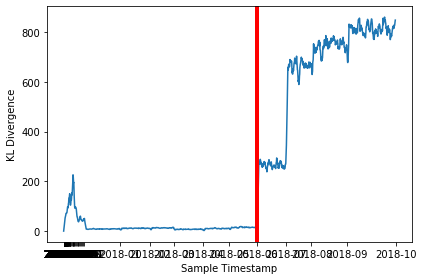

In [5]:
fig, ax = plt.subplots()
ax.plot(list(range(0,len(all_data),500)),total_kl_div)
ax.set_ylabel('KL Divergence')
ax.set_xlabel('Sample Timestamp')
tick_len = 0
cutoff_len = 0
tick_locations = []
dates = [d for d in X_by_month.keys()]
for date in dates:
    if date == "2018-07":
        cutoff_len = tick_len
    tick_len += len(X_by_month[date])
    tick_locations.append(tick_len)
ax.set_xticks(tick_locations)
ax.set_xticklabels(dates)
ax.axvline(x=cutoff_len, linewidth=4, color='r')
fig.tight_layout()
fig.savefig("drift.png", bbox_inches='tight')
plt